The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


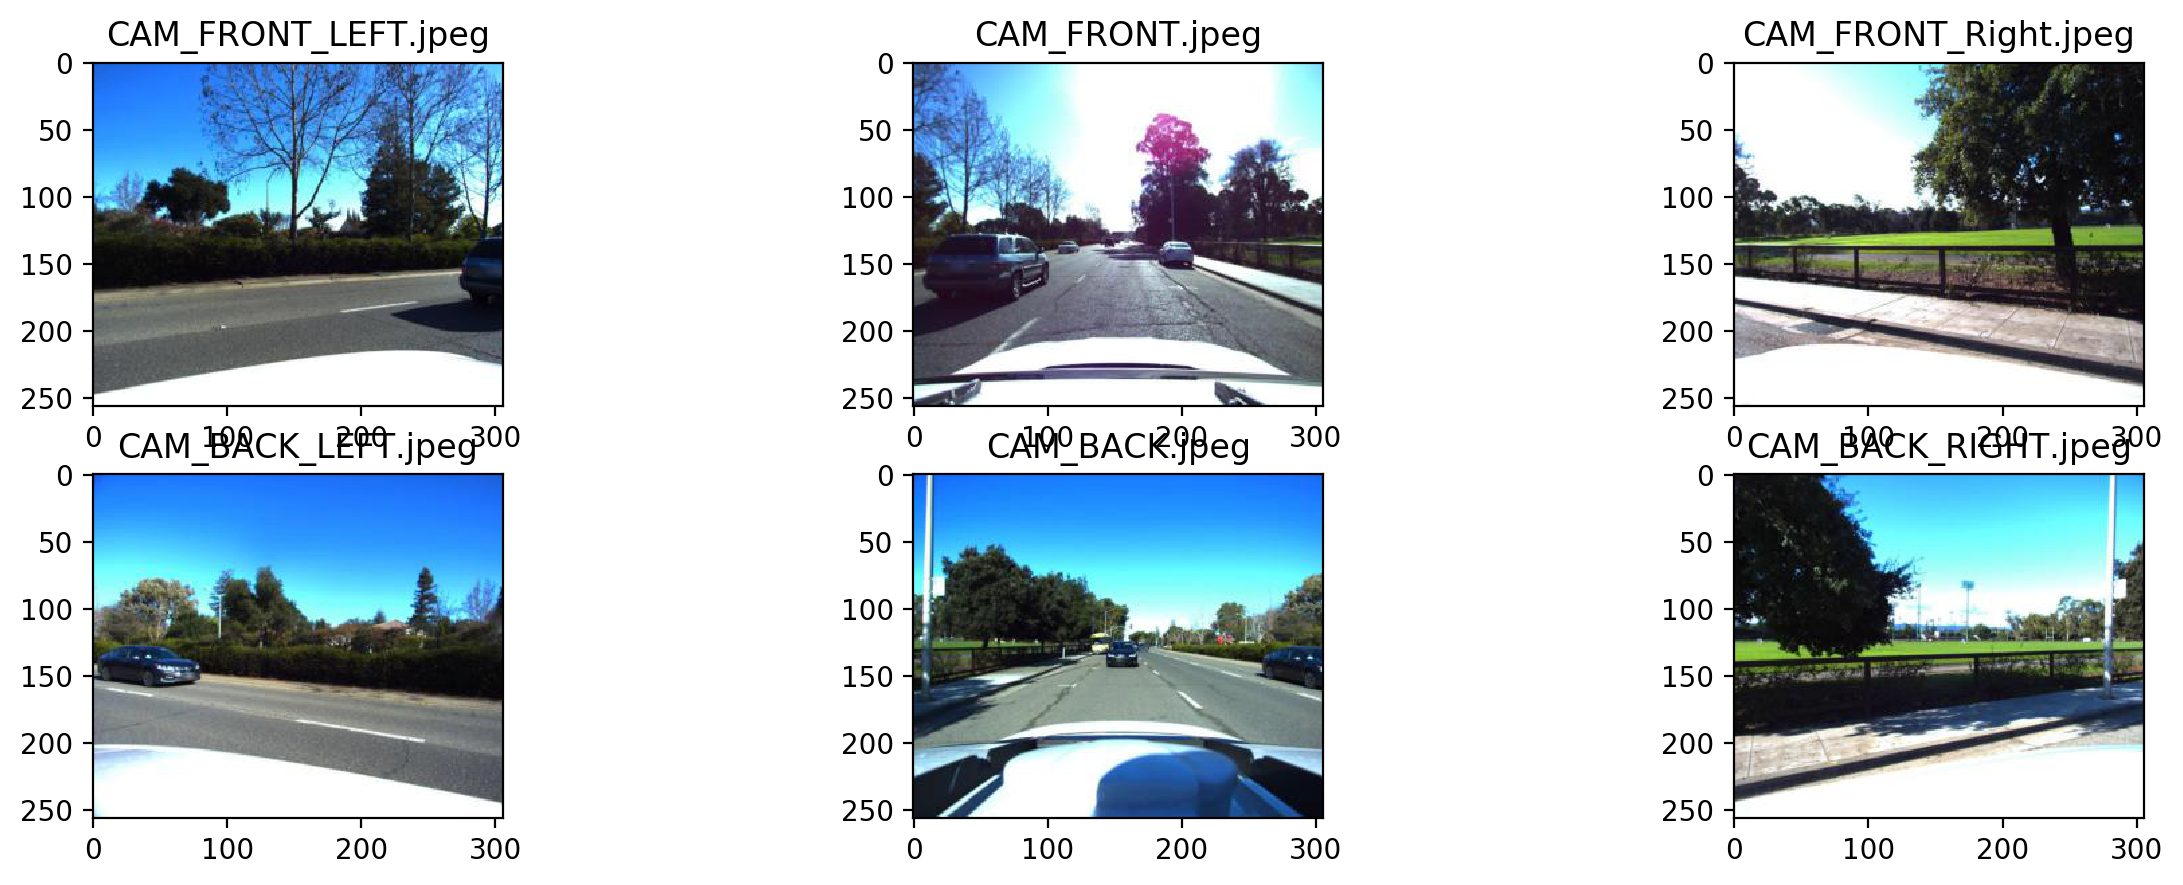

In [70]:
#for testing
import os
import random
#%load_ext autotime
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import LabeledDataset
from helper import collate_fn, draw_box

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

%load_ext autoreload
%autoreload 2

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

labeled_scene_index = np.arange(106, 134)
normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
                                     std=[0.31936955, 0.3117349 , 0.2953726 ])

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                           normalize
                                           ])
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True,
                                 )

trainloader = torch.utils.data.DataLoader(labeled_trainset , batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
samples, target, road_image, extra = iter(trainloader).next()

samples, target, road_image, extra = iter(trainloader).next()

def plot_image(ax,image,title="",**kw_imshow):

    ax.imshow(image,**kw_imshow);
    ax.set_title(title)
    return ax

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

    
denormer = UnNormalize(mean=[0.6394939, 0.6755114, 0.7049375],std=[0.31936955, 0.3117349 , 0.2953726 ])    
    
new_image_names = [
'CAM_FRONT_LEFT.jpeg',
'CAM_FRONT.jpeg',
'CAM_FRONT_Right.jpeg',
'CAM_BACK_LEFT.jpeg',
'CAM_BACK.jpeg',
'CAM_BACK_RIGHT.jpeg'
]

fig, axs = plt.subplots(2,3)
axs = axs.flatten()
for i in range(6):
    plot_image(axs[i],denormer(torch.stack(samples).transpose(0,1)[i][0]).numpy().transpose(1, 2, 0),title=new_image_names[i])


In [71]:
"""
You need to implement all four functions in this file and also put your team info as a variable
Then you should submit the python file with your model class, the state_dict, and this file
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from test_nn import *
from data_helper_triangle_down import plot_mask
from skimage.transform import resize


# import your model class
# import ...

# Put your transform function here, we will use it for our dataloader
def get_transform(): 
    # return torchvision.transforms.Compose([
    # 
    # 
    # ])
    normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
                                     std=[0.31936955, 0.3117349 , 0.2953726 ])

    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                           normalize
                                           ])
    return trainsform

class ModelLoader():
    # Fill the information for your team
    team_name = ''
    team_member = []
    contact_email = '@nyu.edu'

    def __init__(self,model_file):
        # You should 
        #       1. create the model object
        #       2. load your state_dict
        #       3. call cuda()
        # self.model = ...
        # 
        #images ordered according to sample pivot
        self.image_names = [
        'CAM_FRONT_LEFT.jpeg',
        'CAM_FRONT.jpeg',
        'CAM_FRONT_Right.jpeg',
        'CAM_BACK_LEFT.jpeg',
        'CAM_BACK.jpeg',
        'CAM_BACK_RIGHT.jpeg'
        ]
        self.models={}
        self.masks={}
        for idx,image in enumerate(image_names):
            self.models[image]=load_cam_model(image,True,False,False).cuda()
            self.masks[image]=load_mask(image,(100,100))

    def get_bounding_boxes(self,samples):
        # samples is a cuda tensor with size [batch_size, 6, 3, 256, 306]
        # You need to return a tuple with size 'batch_size' and each element is a cuda tensor [N, 2, 4]
        # where N is the number of object

        pass

    def get_binary_road_map(self,samples):
        # samples is a cuda tensor with size [batch_size, 6, 3, 256, 306]
        # You need to return a cuda tensor with size [batch_size, 800, 800] 
        cam_samples = samples.transpose(0,1)
        preds = []
        for idx,image_name in enumerate(image_names):
            model = self.models[image_name]
            cam_sample = cam_samples[idx]
            preds.append(model(cam_sample) > .5)

        target_road_images = []
        
        for image_idx in range(samples.shape[0]):
            pred_im = [pred[image_idx] for pred in preds]     

            target_road_image = torch.zeros((100,100)).cuda()

            for idx,image in enumerate(image_names):
                mask = self.masks[image]
                target_road_image[mask] = target_road_image[mask] + pred_im[idx]
            target_road_image = target_road_image > .5
            resized_trm = resize(target_road_image.cpu(),(800,800))
            target_road_images.append(resized_trm)
        return torch.tensor(target_road_images).cuda()
            
        
m = ModelLoader(None)
res = m.get_binary_road_map(torch.stack(samples).cuda())
plot_mask(res[0].cpu().data.numpy())


'\nYou need to implement all four functions in this file and also put your team info as a variable\nThen you should submit the python file with your model class, the state_dict, and this file\n'

Loading ./models/resnet_1CAM_FRONT.pt
Loading ./models/latest_fe_sd.pt
Loading ./models/resnet_1CAM_FRONT_LEFT.pt
Loading ./models/latest_fe_sd.pt
Loading ./models/resnet_1CAM_BACK_LEFT.pt
Loading ./models/latest_fe_sd.pt
Loading ./models/resnet_1CAM_BACK.pt
Loading ./models/latest_fe_sd.pt
Loading ./models/resnet_1CAM_BACK_RIGHT.pt
Loading ./models/latest_fe_sd.pt
Loading ./models/resnet_1CAM_FRONT_RIGHT.pt
Loading ./models/latest_fe_sd.pt


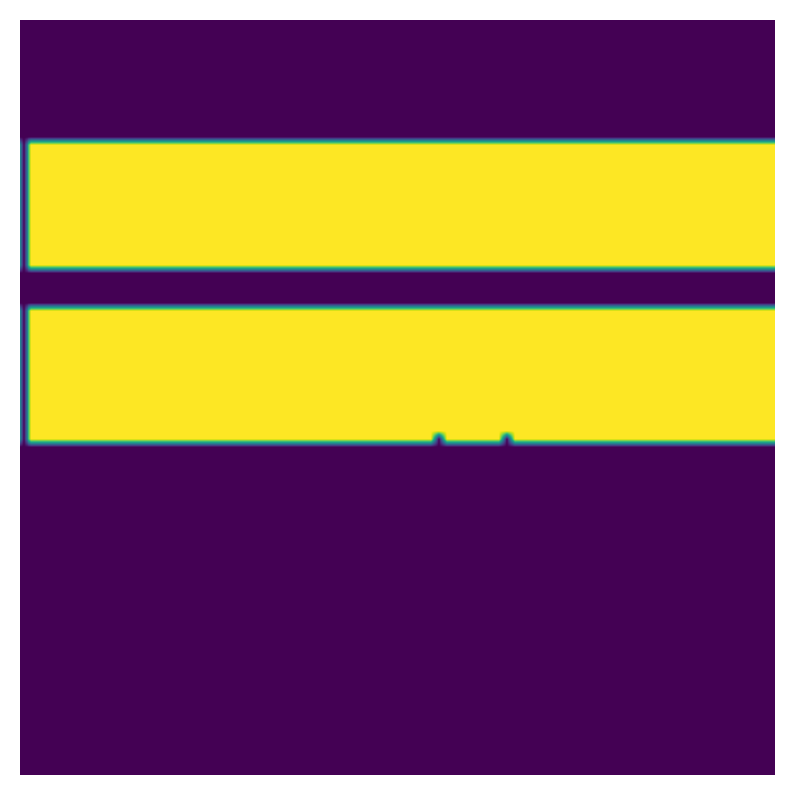

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [61]:
m.models["CAM_FRONT.jpeg"](torch.stack(samples).transpose(1,0)[0].cuda())[0].requires_grad

False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
running /root/dl2020/download_bucket.sh resnet_1CAM_FRONT.pt ./models/resnet_1CAM_FRONT.pt
loading ./models/resnet_1CAM_FRONT.pt
Loading ./models/resnet_1CAM_FRONT.pt
running /root/dl2020/download_bucket.sh resnet_1CAM_FRONT_LEFT.pt ./models/resnet_1CAM_FRONT_LEFT.pt
loading ./models/resnet_1CAM_FRONT_LEFT.pt
Loading ./models/resnet_1CAM_FRONT_LEFT.pt
running /root/dl2020/download_bucket.sh resnet_1CAM_BACK_LEFT.pt ./models/resnet_1CAM_BACK_LEFT.pt
loading ./models/resnet_1CAM_BACK_LEFT.pt
Loading ./models/resnet_1CAM_BACK_LEFT.pt
running /root/dl2020/download_bucket.sh resnet_1CAM_BACK.pt ./models/resnet_1CAM_BACK.pt
loading ./models/resnet_1CAM_BACK.pt
Loading ./models/resnet_1CAM_BACK.pt
running /root/dl2020/download_bucket.sh resnet_1CAM_BACK_RIGHT.pt ./models/resnet_1CAM_BACK_RIGHT.pt
loading ./models/resnet_1CAM_BACK_RIGHT.pt
Loading ./models/resnet_1CAM_BACK_RIGHT.pt
running /root/dl2020/down

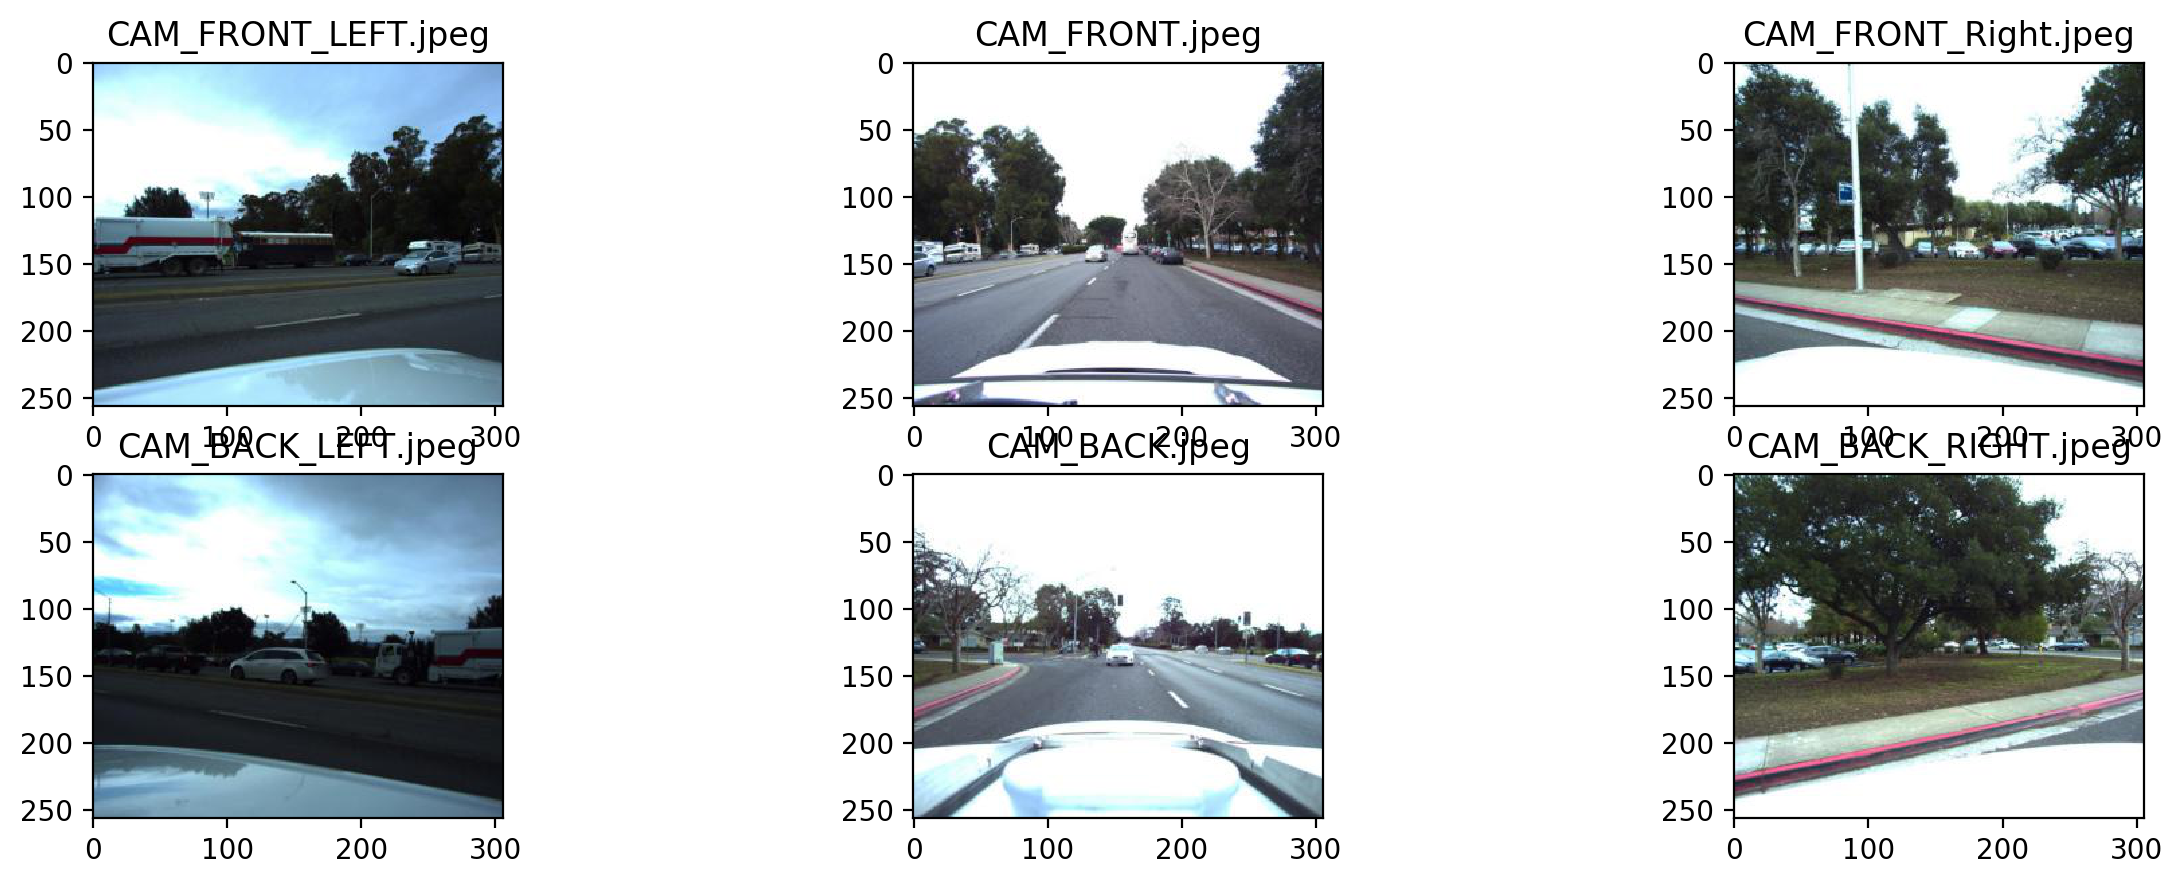

In [19]:
cam_samples = torch.stack(samples).transpose(0,1)
preds = []
for idx,image_name in enumerate(image_names):
    model = models[image_name]
    cam_sample = cam_samples[idx]
    preds.append(model(cam_sample) > .5)

target_road_images = []
for image_idx in range(torch.stack(samples).shape[0]):
    pred_im = [pred[image_idx].data.numpy() for pred in preds]     
    
    target_road_image = np.zeros((100,100))

    for idx,image in enumerate(image_names):
        mask = masks[image]
        target_road_image[mask] = target_road_image[mask] + pred_im[idx]
    target_road_image = target_road_image > .5
    target_road_images.append(target_road_image)

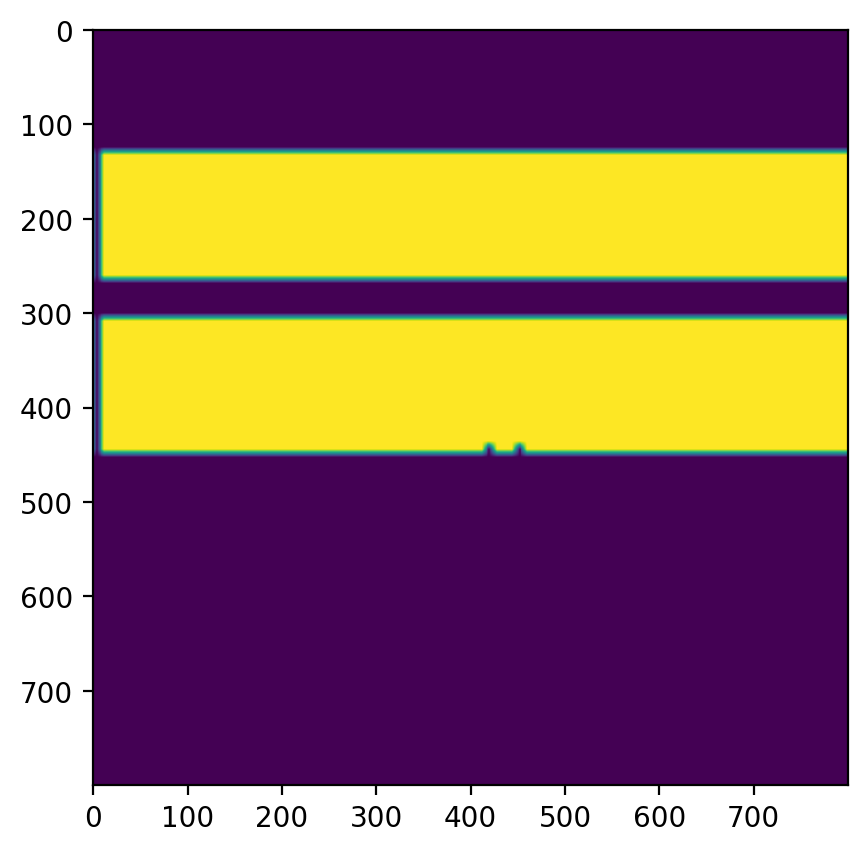

In [23]:
fig, ax = plt.subplots(1,1)
plot_image(ax,resize(target_road_images[0],(800,800)),"")

In [26]:
torch.tensor(target_road_images).shape

torch.Size([2, 100, 100])